## Image classification Practical

***NOTE***

Be sure to use hardware acceleration to use the GPU. Click on `Runtime`, change `runtime type`, and select `GPU` for the *hardware accelerator* option.

<hr>

Total marks: 33

Familiarise yourself with the data set: https://www.cs.toronto.edu/~kriz/cifar.html

Question 1: how many classes are in cifar-10?


There are 10 classes.

Question 2: is this a colour or greyscale image dataset?

It is a greyscale image.

Question 3: how many channels/depth should the images have?


The images have a depth of 3

Question 4: is this a regression or classification problem?


It is a classification problem.

Question 5: if we one-hot encode the targets for this dataset, what will the dimensions of the resulting vector be?

Question 6: which activation function will you most likely use in the last layer of your model for this problem?

In [183]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

In [184]:
from keras.datasets import cifar10

## Load the dataset

In [185]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

#Task: do all preprocessing here

The data is obtained as a training and testing set. Typically, it's a good idea to create a validation set from the training set. Hint: previous pracs illustrated how to do this. Name the validation data as `X_val` and `Y_val`.

All other preprocessing including normalisation, one-hot encoding etc should be added here...

In [186]:
print('Training data shape : ', X_train.shape, Y_train.shape)

Training data shape :  (50000, 32, 32, 3) (50000, 1)


In [187]:
print('Testing data shape : ', X_test.shape, Y_test.shape)

Testing data shape :  (10000, 32, 32, 3) (10000, 1)


In [188]:
classes = np.unique(Y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : [5]')

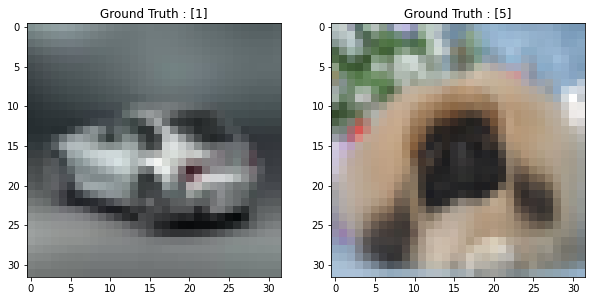

In [189]:
data_point = 250


plt.figure(figsize=[10,5])
 
# Display the first image in training data
plt.subplot(121)
plt.imshow(X_train[data_point,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(Y_train[data_point]))
 
# Display the first image in testing data
plt.subplot(122)
plt.imshow(X_test[data_point,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(Y_test[data_point]))

In [190]:
X_train.shape

(50000, 32, 32, 3)

In [191]:
X_train.shape[0]

50000

In [192]:
X_train.shape[1]

32

In [193]:
X_train_reshaped = np.reshape(X_train,(50000,32,32,3))

In [194]:
X_test_reshaped = np.reshape(X_test,(10000,32,32,3))

In [195]:
X_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [196]:
np.max(X_train[0])

255

In [197]:
X_train = X_train/255

In [198]:
X_test = X_test/255

In [199]:
X_train, X_val, Y_train, Y_val= train_test_split(X_train,Y_train,test_size=0.2)

In [200]:
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)
num_classes = 10

## Create a convolutional neural network

Your network must get at least 70% accuracy on the test set.

Your model must have less than 600,000 weights in total.

Hint: try first with no dropout, then add dropout - what happens, is it bettter or worse?

Hint: try small batch size

In [201]:
def baseline_model():
    # create model
    model = Sequential()
    
    # Since this is the first layer, we need to specify the input shape. Only here, only once.
    # We are creating 64 filters each of size 2x2. What will be the depth of each of those 64 filters?
    # What will be the resulting depth of the feature map after applying these filters?

    # "valid" means no padding. "same" results in padding with zeros evenly to the 
    # left/right or up/down of the input such that output has the same height/width dimension as the input. 
    model.add(Conv2D(filters=64, kernel_size=2, activation='relu', input_shape=(32,32,3))) 
    
    # Here we create a 2x2 max pooling layer
    model.add(MaxPool2D(pool_size=2))

    model.add(Conv2D(filters=110, kernel_size=2, padding='same', activation='relu')) 
    model.add(MaxPool2D(pool_size=2))
    model.add(Conv2D(filters=110, kernel_size=2, padding='same', activation='relu')) 
    model.add(MaxPool2D(pool_size=2))

    # In order to pass output from the convolutional block to the dense block, we must flatten each example in the minibatch. 
    # In other words, we take this four-dimensional input [batch, width, height, depth] and transform it into the two-dimensional input [batch, units/input dimensions] expected by fully-connected layers
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))

    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))

    loss = CategoricalCrossentropy()
    
    # Compile the model
    model.compile(loss=loss,
             optimizer='adam',
             metrics=['accuracy'])
    return model

In [202]:
model = baseline_model()

## Determine the number of trainable parameters

In [203]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 31, 31, 64)        832       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 15, 15, 110)       28270     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 7, 7, 110)        0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 110)         48510     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 3, 3, 110)      

In [204]:
checkpoint_path = "training/cp-{epoch:04d}.ckpt"

cp_callback = ModelCheckpoint(filepath=checkpoint_path, 
                              save_best_only=True, 
                              save_weights_only=True, 
                              verbose=1)

## Train the model


In [205]:
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=1, callbacks=[cp_callback])

Epoch 1/10
248/250 [============================>.] - ETA: 0s - loss: 1.7222 - accuracy: 0.3638
Epoch 00001: val_loss improved from inf to 1.42290, saving model to training/cp-0001.ckpt
250/250 [==============================] - 7s 25ms/step - loss: 1.7192 - accuracy: 0.3650 - val_loss: 1.4229 - val_accuracy: 0.4970
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 1.3346 - accuracy: 0.5237
Epoch 00002: val_loss improved from 1.42290 to 1.20909, saving model to training/cp-0002.ckpt
250/250 [==============================] - 6s 23ms/step - loss: 1.3346 - accuracy: 0.5237 - val_loss: 1.2091 - val_accuracy: 0.5659
Epoch 3/10
249/250 [============================>.] - ETA: 0s - loss: 1.1646 - accuracy: 0.5884
Epoch 00003: val_loss improved from 1.20909 to 1.07860, saving model to training/cp-0003.ckpt
250/250 [==============================] - 6s 24ms/step - loss: 1.1643 - accuracy: 0.5886 - val_loss: 1.0786 - val_accuracy: 0.6217
Epoch 4/10
248/250 [==================

## Plot the performance

Plot the training and validation accuracy in a single plot

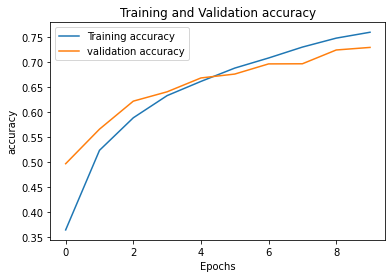

In [206]:
train_accuracy = history.history['accuracy']
Val_accuracy = history.history['val_accuracy']
epochs = range(0,10)
plt.plot( epochs, train_accuracy, label='Training accuracy')
plt.plot(epochs, Val_accuracy, label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Predict on the test data

In [207]:
correct_values = np.argmax(Y_test,axis=1)

In [208]:
# New random initialisation
model = baseline_model()

predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=-1)

accuracy_score(predictions,correct_values)*100

10.47

In [209]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[0.10190456, 0.09312332, 0.09949318, 0.11132542, 0.10022839,
        0.10268286, 0.10707971, 0.08526346, 0.0942136 , 0.10468552]],
      dtype=float32)

In [210]:
prediction = model.predict(np.expand_dims(X_test[0], axis=0))
np.argmax(prediction, axis=-1)

array([3])

In [211]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=-1)

In [212]:
predictions[0:10]

array([3, 6, 3, 3, 3, 6, 3, 3, 6, 3])

## Compute the accuracy

Get at least 65% testing accuracy

In [213]:
# Load a trained model from one of the checkpoints
model = baseline_model()
model.load_weights("training/cp-0010.ckpt")

predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=-1)

accuracy_score(predictions,correct_values)*100

72.50999999999999

## Obtain the confusion matrix

In [214]:
confusion_matrix(predictions,correct_values)

array([[792,  22,  71,  19,  29,  14,   6,  19,  79,  35],
       [ 22, 801,   4,   9,   2,   3,   3,   2,  35,  69],
       [ 47,   5, 668,  75,  88,  79,  54,  43,  11,  10],
       [ 16,  11,  55, 558,  73, 192,  60,  49,  19,  15],
       [ 10,   0,  54,  45, 613,  27,  18,  48,   2,   2],
       [  6,   3,  47, 164,  29, 600,  23,  58,   8,   4],
       [  8,   8,  60,  62,  67,  17, 821,   7,   7,   6],
       [  9,   2,  22,  33,  84,  55,   5, 756,   4,  10],
       [ 55,  33,   9,  16,  13,   7,   9,   1, 815,  22],
       [ 35, 115,  10,  19,   2,   6,   1,  17,  20, 827]])